In [53]:
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75,
    max_num_hands=2
)

cap = cv2.VideoCapture(0)
cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Image", 1280, 720)   # optional starting size


while True:
    success, img = cap.read()
    if not success:
        print("Failed to grab frame")
        break

    # mirror image for webcam-like view
    img = cv2.flip(img, 1)

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    if results.multi_hand_landmarks:
        # if two hands detected, show 'Both Hands'
        if len(results.multi_handedness) == 2:
            cv2.putText(img, 'Both Hands', (250, 50),
                        cv2.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 2)
        # otherwise iterate and get label for each detected hand
        # note: the order of multi_hand_landmarks and multi_handedness is linked,
        # so use the same index for both lists.
        for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # get handedness label directly from the proto object
            # classification is a repeated field; [0] holds the top label
            handedness_proto = results.multi_handedness[idx]
            label = handedness_proto.classification[0].label  # 'Left' or 'Right'

            # choose x position based on label (or use bounding box center if you prefer)
            if label == 'Left':
                x_pos = 20
            else:
                x_pos = img.shape[1] - 140  # near right edge

            cv2.putText(img, f'{label} Hand', (x_pos, 50),
                        cv2.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 2)

            # Optionally draw the landmarks
            mp.solutions.drawing_utils.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.imshow('Image', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [7]:
!pip install pandas matplotlib mediapipe opencv-python

Detected 1 hand. Landmark table (normalized coords and pixel coords):



,name,x_norm,y_norm,z_norm,x_px,y_px
index,,,,,,
0,WRIST,0.933505,0.904381,7.987357e-07,597,434
1,THUMB_CMC,0.795019,0.923558,-6.209354e-02,509,443
2,THUMB_MCP,0.651824,0.791483,-7.827634e-02,417,380
3,THUMB_IP,0.564889,0.650538,-8.687194e-02,362,312
4,THUMB_TIP,0.478866,0.579303,-9.567541e-02,306,278
5,INDEX_MCP,0.676849,0.509296,-5.281031e-02,433,244
6,INDEX_PIP,0.582257,0.341657,-8.585045e-02,373,164
7,INDEX_DIP,0.517857,0.233832,-1.148050e-01,331,112
8,INDEX_TIP,0.466524,0.142698,-1.381812e-01,299,68



Num landmarks: 21 (should be 21).  Shape: (21, 3)


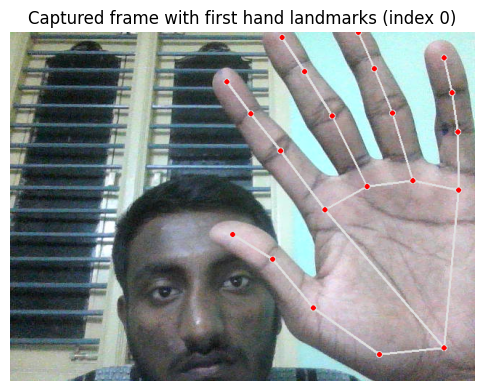

In [59]:
# Paste this entire block into a Jupyter cell and run it.
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75,
    max_num_hands=2
)

# Friendly mapping of landmark index -> anatomical name
LANDMARK_NAMES = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_MCP",
    6: "INDEX_PIP",
    7: "INDEX_DIP",
    8: "INDEX_TIP",
    9: "MIDDLE_MCP",
    10: "MIDDLE_PIP",
    11: "MIDDLE_DIP",
    12: "MIDDLE_TIP",
    13: "RING_MCP",
    14: "RING_PIP",
    15: "RING_DIP",
    16: "RING_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Unable to read from the webcam (device 0). Make sure the camera is connected.")

# Mirror image for a webcam-like view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]

# Convert to RGB for MediaPipe
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Process with MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    # We'll take the first detected hand (index 0)
    hand_landmarks = results.multi_hand_landmarks[0]

    # Build a table of landmark values
    rows = []
    for idx, lm in enumerate(hand_landmarks.landmark):
        x_norm = lm.x
        y_norm = lm.y
        z_norm = lm.z
        x_px = int(round(x_norm * img_w))
        y_px = int(round(y_norm * img_h))
        rows.append({
            "index": idx,
            "name": LANDMARK_NAMES.get(idx, f"LM_{idx}"),
            "x_norm": float(x_norm),
            "y_norm": float(y_norm),
            "z_norm": float(z_norm),
            "x_px": int(x_px),
            "y_px": int(y_px)
        })

    df = pd.DataFrame(rows)
    df = df.set_index("index")
    # Print summary information
    print("Detected 1 hand. Landmark table (normalized coords and pixel coords):\n")
    display(df)   # shows a nice table in Jupyter

    # Also print small summary / shapes
    coords_np = np.array([[r["x_norm"], r["y_norm"], r["z_norm"]] for r in rows])
    print(f"\nNum landmarks: {coords_np.shape[0]} (should be 21).  Shape: {coords_np.shape}")

    # Draw landmarks on the image for visualization
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Show the annotated image inline
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured frame with first hand landmarks (index 0)")
    plt.show()

else:
    print("No hand detected in the captured frame. Try moving your hand in front of the webcam and re-run the cell.")

# Clean up MediaPipe resources
hands.close()


✅ Detected one hand.

📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):
   → Normalized distance: 0.4970
   → Pixel distance: 239.29 pixels



,name,x_norm,y_norm,z_norm,x_px,y_px
index,,,,,,
0,WRIST,0.295322,0.955158,6.932833e-07,189,458
1,THUMB_CMC,0.410518,0.961291,-5.707789e-02,262,461
2,THUMB_MCP,0.523055,0.902301,-8.216686e-02,334,433
3,THUMB_IP,0.610236,0.845829,-1.043458e-01,390,405
4,THUMB_TIP,0.690299,0.837077,-1.265213e-01,441,401
5,INDEX_MCP,0.508530,0.628488,-3.534914e-02,325,301
6,INDEX_PIP,0.574879,0.496367,-6.312954e-02,367,238
7,INDEX_DIP,0.610112,0.416967,-9.013756e-02,390,200
8,INDEX_TIP,0.638329,0.342971,-1.132707e-01,408,164


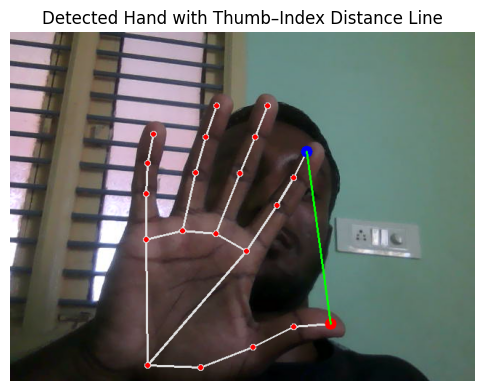

In [31]:
# --- Auto-install required libraries (run only if missing) ---
try:
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install mediapipe opencv-python pandas matplotlib
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

# Landmark names for clarity
LANDMARK_NAMES = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_MCP",
    6: "INDEX_PIP",
    7: "INDEX_DIP",
    8: "INDEX_TIP",
    9: "MIDDLE_MCP",
    10: "MIDDLE_PIP",
    11: "MIDDLE_DIP",
    12: "MIDDLE_TIP",
    13: "RING_MCP",
    14: "RING_PIP",
    15: "RING_DIP",
    16: "RING_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Unable to read from the webcam (device 0). Check camera connection.")

# Mirror for a natural webcam view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]

# Convert BGR → RGB (MediaPipe expects RGB)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Run MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    # Take first detected hand
    hand_landmarks = results.multi_hand_landmarks[0]

    # Store landmarks in a table
    rows = []
    for idx, lm in enumerate(hand_landmarks.landmark):
        x_norm, y_norm, z_norm = lm.x, lm.y, lm.z
        x_px, y_px = int(x_norm * img_w), int(y_norm * img_h)
        rows.append({
            "index": idx,
            "name": LANDMARK_NAMES.get(idx, f"LM_{idx}"),
            "x_norm": x_norm,
            "y_norm": y_norm,
            "z_norm": z_norm,
            "x_px": x_px,
            "y_px": y_px
        })

    df = pd.DataFrame(rows).set_index("index")

    # ---- Calculate Thumb–Index Tip Distance ----
    thumb_tip = df.loc[4]   # THUMB_TIP
    index_tip = df.loc[8]   # INDEX_TIP

    # Normalized distance
    norm_dist = np.sqrt(
        (thumb_tip["x_norm"] - index_tip["x_norm"])**2 +
        (thumb_tip["y_norm"] - index_tip["y_norm"])**2 +
        (thumb_tip["z_norm"] - index_tip["z_norm"])**2
    )

    # Pixel distance (2D)
    pixel_dist = np.sqrt(
        (thumb_tip["x_px"] - index_tip["x_px"])**2 +
        (thumb_tip["y_px"] - index_tip["y_px"])**2
    )

    print("✅ Detected one hand.\n")
    print(f"📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):")
    print(f"   → Normalized distance: {norm_dist:.4f}")
    print(f"   → Pixel distance: {pixel_dist:.2f} pixels\n")

    # Display landmark table
    display(df)

    # Draw landmarks on image
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Highlight Thumb Tip and Index Tip points
    cv2.circle(annotated, (thumb_tip["x_px"], thumb_tip["y_px"]), 8, (0, 0, 255), -1)
    cv2.circle(annotated, (index_tip["x_px"], index_tip["y_px"]), 8, (255, 0, 0), -1)
    cv2.line(annotated,
             (thumb_tip["x_px"], thumb_tip["y_px"]),
             (index_tip["x_px"], index_tip["y_px"]),
             (0, 255, 0), 2)

    # Show annotated image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title("Detected Hand with Thumb–Index Distance Line")
    plt.axis("off")
    plt.show()

else:
    print("⚠️ No hand detected. Try showing your hand clearly to the webcam and re-run the cell.")

# Clean up
hands.close()


✅ Detected one hand.

📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):
   → Normalized distance: 0.4544
   → Pixel distance: 219.65 pixels
   → Approx. real distance: 5.94 cm



,name,x_norm,y_norm,z_norm,x_px,y_px
index,,,,,,
0,WRIST,0.912878,0.897124,6.100247e-07,584,430
1,THUMB_CMC,0.787684,0.881312,-4.623374e-02,504,423
2,THUMB_MCP,0.665082,0.748289,-6.296162e-02,425,359
3,THUMB_IP,0.577256,0.636266,-7.647130e-02,369,305
4,THUMB_TIP,0.489459,0.596473,-8.996493e-02,313,286
5,INDEX_MCP,0.714938,0.493988,-2.780731e-02,457,237
6,INDEX_PIP,0.631809,0.333331,-5.609655e-02,404,159
7,INDEX_DIP,0.581015,0.232555,-8.270156e-02,371,111
8,INDEX_TIP,0.542502,0.145400,-1.043408e-01,347,69


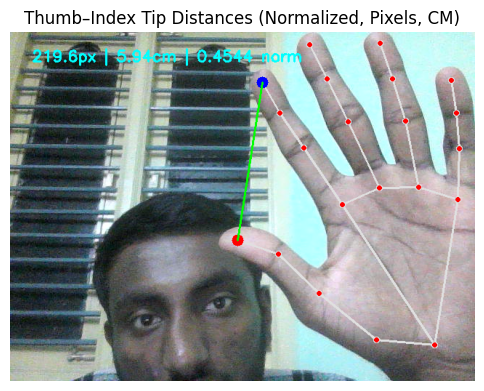

In [63]:
# --- Auto-install required libraries (run only if missing) ---
try:
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install mediapipe opencv-python pandas matplotlib
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

# Landmark names for clarity
LANDMARK_NAMES = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_MCP",
    6: "INDEX_PIP",
    7: "INDEX_DIP",
    8: "INDEX_TIP",
    9: "MIDDLE_MCP",
    10: "MIDDLE_PIP",
    11: "MIDDLE_DIP",
    12: "MIDDLE_TIP",
    13: "RING_MCP",
    14: "RING_PIP",
    15: "RING_DIP",
    16: "RING_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Unable to read from the webcam (device 0). Check camera connection.")

# Mirror for a natural webcam view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]

# Convert BGR → RGB (MediaPipe expects RGB)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Run MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    # Take first detected hand
    hand_landmarks = results.multi_hand_landmarks[0]

    # Store landmarks in a table
    rows = []
    for idx, lm in enumerate(hand_landmarks.landmark):
        x_norm, y_norm, z_norm = lm.x, lm.y, lm.z
        x_px, y_px = int(x_norm * img_w), int(y_norm * img_h)
        rows.append({
            "index": idx,
            "name": LANDMARK_NAMES.get(idx, f"LM_{idx}"),
            "x_norm": x_norm,
            "y_norm": y_norm,
            "z_norm": z_norm,
            "x_px": x_px,
            "y_px": y_px
        })

    df = pd.DataFrame(rows).set_index("index")

    # ---- Calculate Thumb–Index Tip Distances ----
    thumb_tip = df.loc[4]   # THUMB_TIP
    index_tip = df.loc[8]   # INDEX_TIP

    # Normalized distance (scale-invariant 0–1)
    norm_dist = np.sqrt(
        (thumb_tip["x_norm"] - index_tip["x_norm"])**2 +
        (thumb_tip["y_norm"] - index_tip["y_norm"])**2 +
        (thumb_tip["z_norm"] - index_tip["z_norm"])**2
    )

    # Pixel distance (2D)
    pixel_dist = np.sqrt(
        (thumb_tip["x_px"] - index_tip["x_px"])**2 +
        (thumb_tip["y_px"] - index_tip["y_px"])**2
    )

    # ---- Convert Pixel → Centimeters (Calibration Factor) ----
    # Estimate: adjust this factor for your camera setup
    # Example: 1 cm ≈ 37 pixels → 1 px = 0.027 cm
    cm_per_pixel = 1 / 37.0
    dist_cm = pixel_dist * cm_per_pixel

    # --- Print Results ---
    print("✅ Detected one hand.\n")
    print(f"📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):")
    print(f"   → Normalized distance: {norm_dist:.4f}")
    print(f"   → Pixel distance: {pixel_dist:.2f} pixels")
    print(f"   → Approx. real distance: {dist_cm:.2f} cm\n")

    # Display landmark table
    display(df)

    # --- Draw landmarks and distance line ---
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Highlight Thumb Tip and Index Tip points
    cv2.circle(annotated, (thumb_tip["x_px"], thumb_tip["y_px"]), 8, (0, 0, 255), -1)
    cv2.circle(annotated, (index_tip["x_px"], index_tip["y_px"]), 8, (255, 0, 0), -1)
    cv2.line(annotated,
             (thumb_tip["x_px"], thumb_tip["y_px"]),
             (index_tip["x_px"], index_tip["y_px"]),
             (0, 255, 0), 2)

    # Add distance text on image
    cv2.putText(annotated,
                f"{pixel_dist:.1f}px | {dist_cm:.2f}cm | {norm_dist:.4f} norm",
                (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    # Show annotated image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title("Thumb–Index Tip Distances (Normalized, Pixels, CM)")
    plt.axis("off")
    plt.show()

else:
    print("⚠️ No hand detected. Try showing your hand clearly to the webcam and re-run the cell.")

# Clean up
hands.close()
# ring measure................

In [64]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=1
)

# Open webcam
cap = cv2.VideoCapture(0)

# Calibration factor (pixels to cm) — adjust for accuracy
CM_PER_PIXEL = 1 / 37.0

while True:
    success, img = cap.read()
    if not success:
        print("Failed to grab frame.")
        break

    # Flip for a mirror-like view
    img = cv2.flip(img, 1)
    h, w, _ = img.shape

    # Convert BGR → RGB for MediaPipe
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Get thumb tip (4) and index tip (8)
            thumb_tip = hand_landmarks.landmark[4]
            index_tip = hand_landmarks.landmark[8]

            # Convert normalized coordinates → pixels
            thumb_x, thumb_y = int(thumb_tip.x * w), int(thumb_tip.y * h)
            index_x, index_y = int(index_tip.x * w), int(index_tip.y * h)

            # Calculate Euclidean distance (in pixels)
            dist_pixels = np.sqrt((thumb_x - index_x) ** 2 + (thumb_y - index_y) ** 2)
            dist_cm = dist_pixels * CM_PER_PIXEL

            # Draw line and points
            cv2.circle(img, (thumb_x, thumb_y), 8, (0, 0, 255), -1)
            cv2.circle(img, (index_x, index_y), 8, (255, 0, 0), -1)
            cv2.line(img, (thumb_x, thumb_y), (index_x, index_y), (0, 255, 0), 2)

            # Display distance
            cv2.putText(img, f"{dist_cm:.2f} cm", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    cv2.imshow("Hand Distance", img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
# video capturing.............

In [65]:
# --- Auto-install required libraries (run only if missing) ---
try:
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
except ModuleNotFoundError:
    !pip install mediapipe opencv-python pandas
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=1
)

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("❌ Unable to read from webcam. Check camera connection.")

# Mirror for a natural view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Process with MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    hand_landmarks = results.multi_hand_landmarks[0]

    # --- Get Thumb Tip (4) and Index Tip (8) landmarks ---
    thumb_tip = hand_landmarks.landmark[4]
    index_tip = hand_landmarks.landmark[8]

    # Convert normalized coords → pixels
    thumb_px = int(thumb_tip.x * img_w)
    thumb_py = int(thumb_tip.y * img_h)
    index_px = int(index_tip.x * img_w)
    index_py = int(index_tip.y * img_h)

    # --- Distance calculations ---
    norm_dist = np.sqrt(
        (thumb_tip.x - index_tip.x)**2 +
        (thumb_tip.y - index_tip.y)**2 +
        (thumb_tip.z - index_tip.z)**2
    )

    pixel_dist = np.sqrt(
        (thumb_px - index_px)**2 +
        (thumb_py - index_py)**2
    )

    # Convert pixel distance → cm (approx 37.8 px/cm, depends on camera)
    cm_dist = pixel_dist / 37.8

    # --- Draw annotations ---
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.circle(annotated, (thumb_px, thumb_py), 10, (0, 0, 255), -1)
    cv2.circle(annotated, (index_px, index_py), 10, (255, 0, 0), -1)
    cv2.line(annotated, (thumb_px, thumb_py), (index_px, index_py), (0, 255, 0), 2)

    # Display distance on the image
    cv2.putText(
        annotated,
        f"Dist: {pixel_dist:.1f}px | {cm_dist:.2f}cm",
        (30, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (255, 255, 255),
        2
    )

    # --- Save the captured frame ---
    cv2.imwrite("thumb_index_distance.jpg", annotated)
    print("✅ Image captured and saved as 'thumb_index_distance.jpg'")
    print(f"📏 Thumb–Index Distance:")
    print(f"   → Normalized: {norm_dist:.4f}")
    print(f"   → Pixel: {pixel_dist:.2f}px")
    print(f"   → Approx: {cm_dist:.2f}cm")

    # --- Show the annotated image ---
    cv2.imshow("Thumb–Index Distance", annotated)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

else:
    print("⚠️ No hand detected. Show your hand clearly and re-run the code.")

# --- Clean up ---
hands.close()


✅ Image captured and saved as 'thumb_index_distance.jpg'
📏 Thumb–Index Distance:
   → Normalized: 0.4307
   → Pixel: 206.06px
   → Approx: 5.45cm


In [66]:
import cv2
import mediapipe as mp
import numpy as np
import time

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=2,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.7)

# Moving average buffer for smoothing distance
distance_buffer = []
BUFFER_SIZE = 5  # smooth over last 5 frames

# Calibration constant — adjust to match your setup
# (You can use a ruler to calibrate: measure actual cm for known pixel distance)
PIXELS_PER_CM = 20.0  # example: 20 pixels = 1 cm (tune this for your camera)

# Start webcam
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

print("Press 'c' to capture image, 'q' to quit.")

while True:
    success, image = cap.read()
    if not success:
        break

    # Convert to RGB for MediaPipe
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_image)

    # Draw results on the frame
    if results.multi_hand_landmarks and results.multi_handedness:
        for hand_landmarks, hand_label in zip(results.multi_hand_landmarks, results.multi_handedness):
            # Get label (Left or Right)
            label = hand_label.classification[0].label

            # Only process Right hand
            if label == "Right":
                h, w, _ = image.shape
                thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
                index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]

                # Convert to pixel coordinates
                x1, y1 = int(thumb_tip.x * w), int(thumb_tip.y * h)
                x2, y2 = int(index_tip.x * w), int(index_tip.y * h)

                # Calculate Euclidean distance
                distance_pixels = np.linalg.norm(np.array([x2 - x1, y2 - y1]))

                # Convert to cm
                distance_cm = distance_pixels / PIXELS_PER_CM

                # Add to smoothing buffer
                distance_buffer.append(distance_cm)
                if len(distance_buffer) > BUFFER_SIZE:
                    distance_buffer.pop(0)
                smoothed_distance = np.mean(distance_buffer)

                # Draw lines and points
                cv2.circle(image, (x1, y1), 8, (0, 255, 0), -1)
                cv2.circle(image, (x2, y2), 8, (0, 255, 0), -1)
                cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

                # Show distance
                cv2.putText(image, f"Distance: {smoothed_distance:.2f} cm",
                            (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

                # Draw hand landmarks
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Display result
    cv2.imshow("Hand Distance Measurement", image)

    # Capture or quit
    key = cv2.waitKey(1) & 0xFF
    if key == ord('c'):
        timestamp = int(time.time())
        filename = f"capture_{timestamp}.png"
        cv2.imwrite(filename, image)
        print(f"Image saved as {filename}")
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'c' to capture image, 'q' to quit.


In [73]:
import cv2
import mediapipe as mp
import numpy as np
import time

# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=2,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.7)

# Calibration (adjust after ruler test)
PIXELS_PER_CM = 20.0
BUFFER_SIZE = 5
distance_buffer = []

# Define color map for different lines
COLORS = {
    "finger_gap": (0, 255, 0),     # Green
    "palm_length": (255, 0, 0),    # Blue
    "palm_width": (0, 0, 255),     # Red
}

# Finger tip pairs
FINGER_PAIRS = [(4, 8), (8, 12), (12, 16), (16, 20)]

# Palm measures
PALM_LENGTH = (0, 12)
PALM_WIDTH = (5, 17)

cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

print("Press 'q' to quit.")

while True:
    success, frame = cap.read()
    if not success:
        break

    # Flip and convert
    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)

    if results.multi_hand_landmarks and results.multi_handedness:
        for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            if handedness.classification[0].label == "Right":
                h, w, _ = frame.shape
                landmarks = [(int(lm.x * w), int(lm.y * h)) for lm in hand_landmarks.landmark]

                # 1.Distance between each adjacent fingertip
                for (p1, p2) in FINGER_PAIRS:
                    x1, y1 = landmarks[p1]
                    x2, y2 = landmarks[p2]
                    dist_px = np.linalg.norm(np.array([x2 - x1, y2 - y1]))
                    dist_cm = dist_px / PIXELS_PER_CM
                    cv2.line(frame, (x1, y1), (x2, y2), COLORS["finger_gap"], 2)
                    mid_x, mid_y = (x1 + x2) // 2, (y1 + y2) // 2
                   # cv2.putText(frame, f"{dist_cm:.1f}cm", (mid_x - 25, mid_y - 10),
                    #            cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS["finger_gap"], 1)

                # 2. Palm length (Wrist to Middle Tip)
                x1, y1 = landmarks[PALM_LENGTH[0]]
                x2, y2 = landmarks[PALM_LENGTH[1]]
                palm_len_px = np.linalg.norm(np.array([x2 - x1, y2 - y1]))
                palm_len_cm = palm_len_px / PIXELS_PER_CM
                cv2.line(frame, (x1, y1), (x2, y2), COLORS["palm_length"], 2)
                #cv2.putText(frame, f"{palm_len_cm:.1f}cm",
                 #           (x1 + 20, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                  #          0.6, COLORS["palm_length"], 2)

                # 3. Palm width (Index base to Pinky base)
                x3, y3 = landmarks[PALM_WIDTH[0]]
                x4, y4 = landmarks[PALM_WIDTH[1]]
                palm_wid_px = np.linalg.norm(np.array([x4 - x3, y4 - y3]))
                palm_wid_cm = palm_wid_px / PIXELS_PER_CM
                cv2.line(frame, (x3, y3), (x4, y4), COLORS["palm_width"], 2)
                #cv2.putText(frame, f"{palm_wid_cm:.1f}cm",
                 #           (x3 + 20, y3 + 20), cv2.FONT_HERSHEY_SIMPLEX,
                  #          0.6, COLORS["palm_width"], 2)

                # Draw landmarks
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)


    cv2.imshow("Hand Measurements", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
print('Approx. values:(in cm)')
print( 'palm width:',round(palm_wid_cm))
print('palm lenght:',round(palm_len_cm))
print('Distace b/w thumb and index:',round(dist_cm))

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit.
Approx. values:(in cm)
palm width: 8
palm lenght: 24
Distace b/w thumb and index: 5
